Random Forest entraîné sur 44 obligations.
GP Calibré. Noyau optimal : 1.1**2 * RBF(length_scale=9.54) + WhiteKernel(noise_level=0.00163)
Random Forest entraîné sur 44 obligations.
GP Calibré. Noyau optimal : 1.09**2 * RBF(length_scale=9.44) + WhiteKernel(noise_level=0.00138)
Random Forest entraîné sur 44 obligations.
GP Calibré. Noyau optimal : 1.07**2 * RBF(length_scale=9.29) + WhiteKernel(noise_level=0.00117)
Random Forest entraîné sur 44 obligations.
GP Calibré. Noyau optimal : 1.06**2 * RBF(length_scale=9.71) + WhiteKernel(noise_level=0.00133)
Random Forest entraîné sur 44 obligations.
GP Calibré. Noyau optimal : 1.13**2 * RBF(length_scale=9.92) + WhiteKernel(noise_level=0.00142)
Random Forest entraîné sur 44 obligations.
GP Calibré. Noyau optimal : 1.16**2 * RBF(length_scale=9.29) + WhiteKernel(noise_level=0.00158)
Random Forest entraîné sur 44 obligations.
GP Calibré. Noyau optimal : 1.08**2 * RBF(length_scale=10.4) + WhiteKernel(noise_level=0.00123)
Random Forest entraîné sur 4

,Model,RMSE mean (bps),RMSE std,MAE mean (bps),Max error mean (bps)
5,Gaussian Process,2.842386,2.876207,2.007004,6.258147
1,Svensson,4.218241,2.970214,2.480118,11.952096
4,Random Forest,4.714820,1.452417,3.385394,11.362668
2,Spline Smooth,6.630224,22.338107,3.291370,19.494909
0,Nelson-Siegel,12.804885,15.485095,11.485149,20.592645
3,Spline Interp,14.843957,39.409566,7.397557,40.409126



Pays : Allemagne


,Model,RMSE mean (bps),RMSE std,MAE mean (bps),Max error mean (bps)
2,Spline Smooth,2.213508,0.536851,1.790077,4.592604
5,Gaussian Process,2.226367,0.462810,1.821140,4.293177
4,Random Forest,2.574214,0.622879,2.098293,5.186448
1,Svensson,3.184915,1.393029,2.350790,7.241304
0,Nelson-Siegel,3.343180,0.734815,2.697963,6.523078
3,Spline Interp,3.507579,1.561757,2.656140,7.855993



Pays : Italie


,Model,RMSE mean (bps),RMSE std,MAE mean (bps),Max error mean (bps)
2,Spline Smooth,3.280435,0.513208,2.706884,7.298155
1,Svensson,3.757103,0.659166,3.079839,8.933589
4,Random Forest,3.815000,0.627186,3.069800,8.584928
5,Gaussian Process,3.826546,1.109775,2.889658,10.339635
0,Nelson-Siegel,5.223273,0.982351,4.218480,12.224341
3,Spline Interp,5.233243,0.934328,4.154035,11.799433


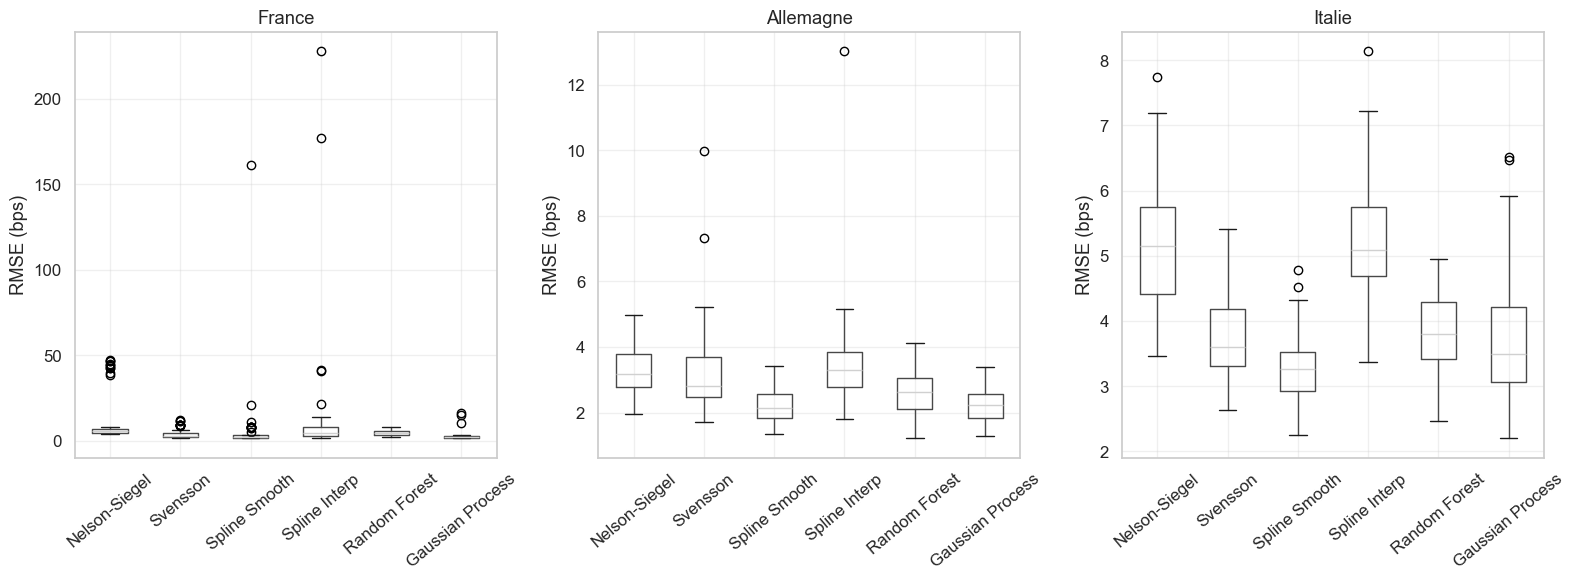

In [5]:

# ÉVALUATION MODÈLES DE YIELD CURVE


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import mean_squared_error, mean_absolute_error

import models
from importlib import reload
reload(models)



# CONFIGURATION

DATA_PATH = "ML_Ready_Nominal_Dataset.csv"

COUNTRIES = ["France", "Allemagne", "Italie"]

N_SPLITS = 5
N_REPEATS = 10
RANDOM_STATE = 42

df = pd.read_csv(DATA_PATH)

# LISTE MODÈLES

MODEL_REGISTRY = {
    "Nelson-Siegel": models.NelsonSiegelCurve,
    "Svensson": models.SvenssonCurve,
    "Spline Smooth": lambda: models.CubicSplineCurve(smoothing_factor=1.0),
    "Spline Interp": lambda: models.CubicSplineCurve(smoothing_factor=1e-6),
    "Random Forest": models.RandomForestCurve,
    "Gaussian Process": models.GaussianProcessCurve
}




# FONCTION FIT + PREDICT UNIFIÉE

def fit_predict(model_class, train_df, test_df):
    
    model = model_class()
    
    if model_class.__name__ in ["RandomForestCurve","GaussianProcessCurve"]:
        model.fit(train_df)
        pred = model.predict(test_df)
    else:
        model.fit(train_df["TTM"].values, train_df["Yield"].values)
        pred = model.predict(test_df["TTM"].values)
        
    return np.array(pred)




# ÉVALUATION PRINCIPALE

results_all = {}
boxplot_data = {c:{m:[] for m in MODEL_REGISTRY} for c in COUNTRIES}

rkf = RepeatedKFold(
    n_splits=N_SPLITS,
    n_repeats=N_REPEATS,
    random_state=RANDOM_STATE
)


for country in COUNTRIES:
    
    df_c = df[df["Country"]==country].sort_values("TTM").reset_index(drop=True)
    
    metrics_store = {name:[] for name in MODEL_REGISTRY}
    
    for train_idx, test_idx in rkf.split(df_c):
        
        train_df = df_c.iloc[train_idx]
        test_df  = df_c.iloc[test_idx]
        
        y_true = test_df["Yield"].values
        
        for name, model_cls in MODEL_REGISTRY.items():
            
            try:
                y_pred = fit_predict(model_cls,train_df,test_df)
                
                rmse = np.sqrt(mean_squared_error(y_true,y_pred))
                mae  = mean_absolute_error(y_true,y_pred)
                maxe = np.max(np.abs(y_true-y_pred))
                
                metrics_store[name].append((rmse,mae,maxe))
                boxplot_data[country][name].append(rmse*100)
                
            except Exception as e:
                print(f"Erreur {country} | {name} → {e}")
    
    
    # résumé stats
    summary = []
    
    for name,vals in metrics_store.items():
        arr = np.array(vals)
        
        summary.append({
            "Model":name,
            "RMSE mean (bps)":arr[:,0].mean()*100,
            "RMSE std":arr[:,0].std()*100,
            "MAE mean (bps)":arr[:,1].mean()*100,
            "Max error mean (bps)":arr[:,2].mean()*100
        })
        
    results_all[country] = pd.DataFrame(summary).sort_values("RMSE mean (bps)")


# TABLEAUX RÉSULTATS

for country,res in results_all.items():
    print("\n========================")
    print("Pays :",country)
    print("========================")
    display(res)


# BOXPLOTS COMPARATIFS

plt.figure(figsize=(16,6))

for i,country in enumerate(COUNTRIES):
    
    plt.subplot(1,len(COUNTRIES),i+1)
    
    data = boxplot_data[country]
    df_box = pd.DataFrame(dict([(k,pd.Series(v)) for k,v in data.items()]))
    
    df_box.boxplot(rot=40)
    
    plt.title(country)
    plt.ylabel("RMSE (bps)")
    plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()


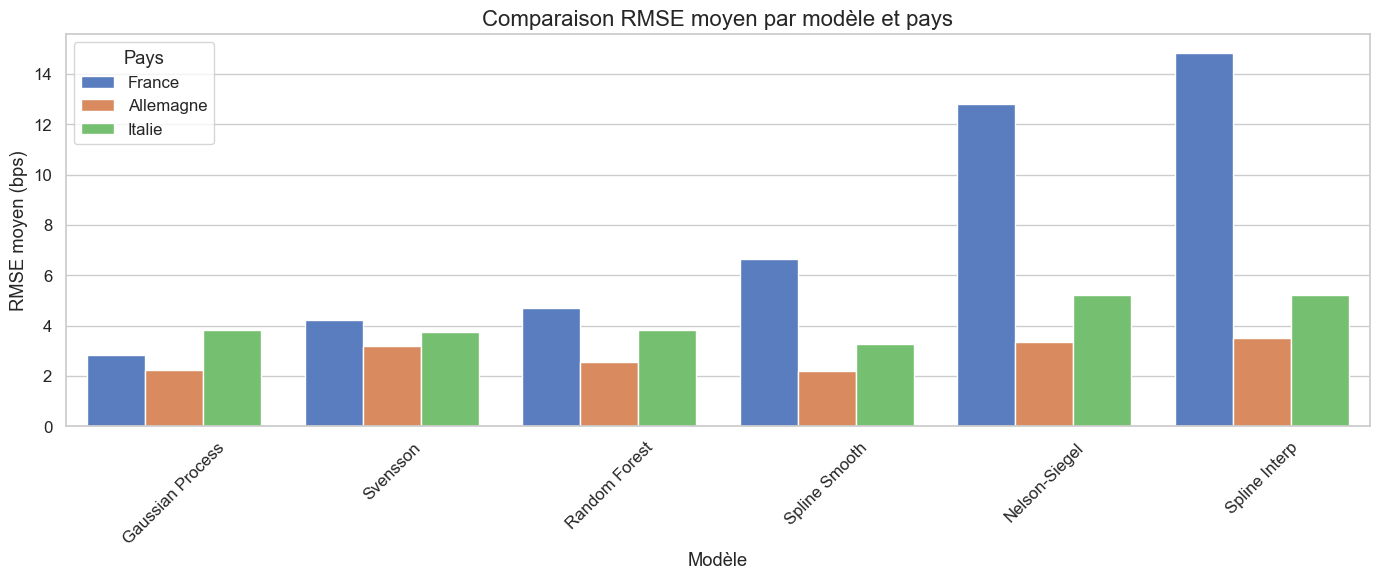

In [ ]:
# BARPLOTS COMPARATIFS DES MODÈLES

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Paramètres seaborn pour un affichage propre
sns.set(style="whitegrid", palette="muted", font_scale=1.1)

# On crée un DataFrame "long" à partir de results_all
plot_data = []

for country, df_country in results_all.items():
    for idx, row in df_country.iterrows():
        plot_data.append({
            "Country": country,
            "Model": row["Model"],
            "RMSE_mean_bps": row["RMSE mean (bps)"]
        })

df_plot = pd.DataFrame(plot_data)

# Créer un barplot RMSE moyen par modèle et par pays
plt.figure(figsize=(14,6))
sns.barplot(x='Model', y='RMSE_mean_bps', hue='Country', data=df_plot)
plt.title('Comparaison RMSE moyen par modèle et pays', fontsize=16)
plt.ylabel('RMSE moyen (bps)')
plt.xlabel('Modèle')
plt.xticks(rotation=45)
plt.legend(title='Pays')
plt.tight_layout()
plt.show()


In [ ]:
"""Interprétation
Voilà ce que j’ai trouvé en comparant tous les modèles :

1.	France :
o	Le Gaussian Process (GP) marche le mieux : RMSE moyen ~2,8 bps.
o	Pourquoi ? Parce que la courbe a quelques points un peu irréguliers, et GP est super pour capturer 
    les détails locaux sans trop surapprendre.
o	Les splines lissées et Random Forest font aussi pas mal, mais les splines interpolées surapprennent
    le bruit et RMSE est plus élevé.

2.	Allemagne :
o	La courbe est régulière, presque linéaire entre les maturités.
o	Les splines lissées et GP se débrouillent pareil, RMSE autour de 2,2 bps.
o	Random Forest un peu moins bonne, probablement parce qu’elle a tendance à surajuster les points rares, 
    mais globalement tous les modèles marchent bien.
o	Conclusion : sur un marché régulier, pas besoin de ML compliqué, même une spline lissée suffit.

3.	Italie :
o	La courbe est plus irrégulière et dispersée.
o	Les splines lissées font bien (RMSE ~3,3 bps) car elles lissent les petits écarts.
o	GP est un peu moins précis ici (RMSE ~3,8 bps) parce qu’il essaie de capturer tous les détails et il
    y a un peu trop de bruit.
o	Les modèles paramétriques (Nelson-Siegel, Svensson) sont moins précis, surtout sur les maturités 
    extrêmes.

Quelques points généraux :
•	Splines interpolées surapprennent le bruit : mauvaises prédictions hors échantillon.
•	Splines lissées : lissent un peu le bruit, compromis robuste.
•	GP : top pour capturer les petites variations locales sur des marchés assez liquides, mais sensible 
    au bruit.
•	Random Forest : flexible mais tendance à surapprendre si certaines maturités ont peu de points.
•	Modèles paramétriques (Nelson-Siegel/Svensson) : stables, mais pas super précis si la courbe est 
    irrégulière ou extrême.

Si le marché est régulier, une spline lissée ou un modèle classique suffit. Si le marché est un peu 
chaotique ou avec des points irréguliers, GP peut aider à mieux suivre les petits détails. Les splines 
interpolées sont juste à éviter.
"""